# TME 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [1]:
# Load useful library
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

# copy here useful functions previously seen
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n = 2*np.ceil(3*sigma) + 1
    x,y = np.meshgrid(np.arange(-n//2,n//2),np.arange(-n//2,n//2))
    return  np.exp( (-x**2-y**2)/(2*sigma*sigma))

def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussian_kernel3()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [2]:
def computeR(image,sigma,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    Sx=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sy=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    Ix=scipy.signal.convolve2d(image,Sx,'same')
    Iy=scipy.signal.convolve2d(image,Sy,'same')
    Ix2=Ix*Ix
    Iy2=Iy*Iy
    Ixy=Ix*Iy
    gaussian=gaussianKernel(sigma)
    A=scipy.signal.convolve2d(Ix2,gaussian,'same')
    B=scipy.signal.convolve2d(Iy2,gaussian,'same')
    C=scipy.signal.convolve2d(Ixy,gaussian,'same')
    det=np.zeros((256, 256))
    trace=np.zeros((256, 256))
    R=np.zeros((256, 256))
    det=A*B-C**2
    trace=A+B
    R=det-kappa*(trace**2)
    return R


2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

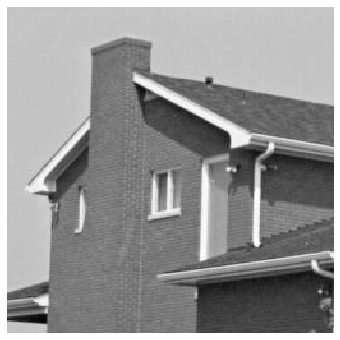

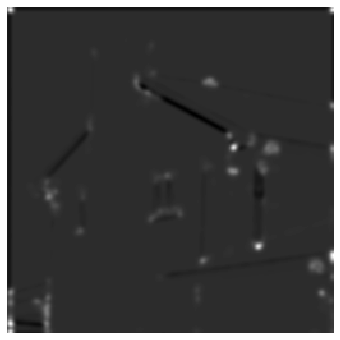

In [3]:
house2_png=np.array(Image.open('img/house2.png'))
imshow(house2_png)

#n = 2*np.ceil(3*sigma) + 1
# sigma =(15-1)/6   w=n=15  

Harrisresp_house2=computeR(house2_png,2.3,0.04)
imshow(Harrisresp_house2)

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

Les coins sont affichés en blanc (représentent des valeurs positives), les contours sont en noirs (représentent des valeurs négatives) et les zones homogènes sont affichées en gris (représentent des valeurs proche de zéro). Ce qui nous permet de les différencier facilement.

Toutefois il y a un problème : des contours et des coins sont détectés sur les bords de l'image. On pourrait résoudre ce problème en utilisant une autre technique pour faire le padding autour de l'image.


## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

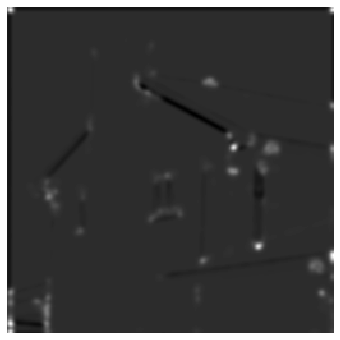

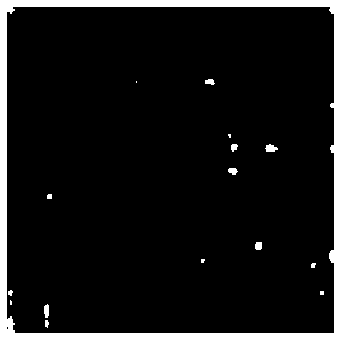

In [10]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return(np.where(R < thres, 0, 1))
    
imshow(Harrisresp_house2)
imshow(thresholdR(Harrisresp_house2,1000000000000))

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 4 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

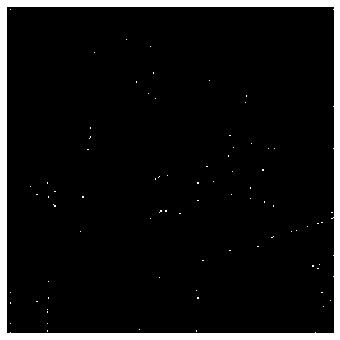

In [13]:
def Rnms(image_harris,Rbin):
    """ Array[n, m] -> Array[n, m] 
    """
    left=np.greater(image_harris, np.roll(image_harris, 1, axis = 1))
    right=np.greater(image_harris, np.roll(image_harris, -1, axis = 1))
    up=np.greater(image_harris, np.roll(image_harris, 1, axis = 0))
    down=np.greater(image_harris, np.roll(image_harris, -1, axis = 0))
    Rnmsup=np.zeros(image_harris.shape)
    for x in range(image_harris.shape[0]):
        for y in range(image_harris.shape[1]):
            if(left[x,y] and right[x,y] and up[x,y] and down[x,y] and Rbin[x,y]==1):
                Rnmsup[x,y]=True
    
    return(Rnmsup)
    
Rnmsup_house=Rnms(Harrisresp_house2,thresholdR(Harrisresp_house2,10**10))

imshow(Rnmsup_house)

3) Write a function ``cornerDetector(image, sigma, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

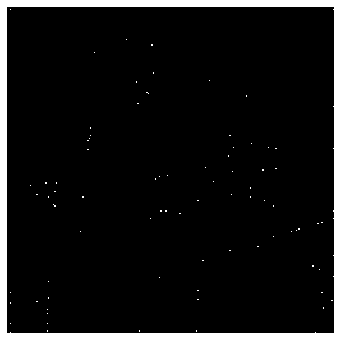

In [14]:
def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    Harrisresp_image=computeR(image,sigma,kappa)
    Rbin=thresholdR(Harrisresp_image,thres)
    Rnmsup_image=Rnms(Harrisresp_image,Rbin)
    return Rnmsup_image

imshow(cornerDetector(np.array(Image.open('img/house2.png')),2.1,0.04,10**10))

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

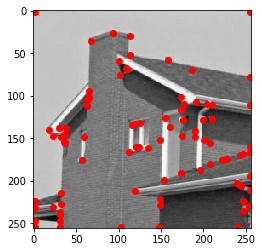

In [26]:
def displayCorner(image, sigma, kappa, thres):
    corner_image=cornerDetector(image,sigma,kappa,thres)
    nonzero=np.nonzero(corner_image)

    for x in range(0,len(nonzero),2):
        plt.scatter(nonzero[x+1],nonzero[x],c="r")
    plt.imshow(image)
    plt.show()

displayCorner(house2_png,2.1,0.04,10**10)


# méthode facile

#     for x in range(0,len(nonzero[0])):
#         plt.scatter(nonzero[1][x],nonzero[0][x],c="r")


5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

#### on fait varier sigma:

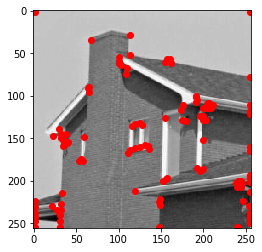

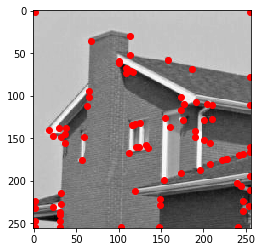

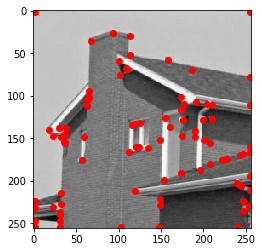

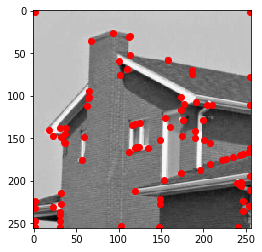

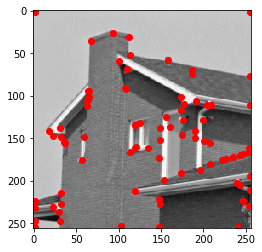

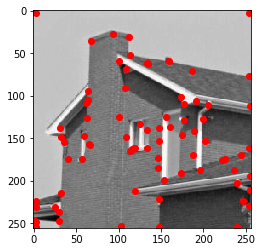

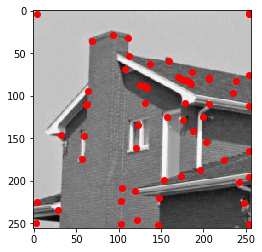

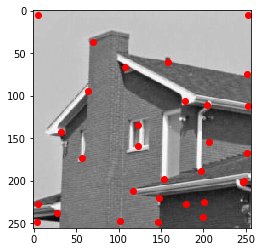

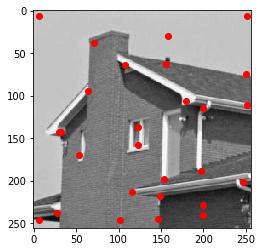

In [22]:
displayCorner(house2_png,1,0.04,10**10)
displayCorner(house2_png,2,0.04,10**10)
displayCorner(house2_png,2.1,0.04,10**10)
displayCorner(house2_png,2.2,0.04,10**10)
displayCorner(house2_png,2.5,0.04,10**10)
displayCorner(house2_png,3,0.04,10**10)
displayCorner(house2_png,5,0.04,10**10)
displayCorner(house2_png,8,0.04,10**10)
displayCorner(house2_png,10,0.04,10**10)

Le détecteur semble fonctionner au mieux lorsque sigma est proche de 2. En particulier pour sigma = 2.1 ou sigma = 2.2

Plus on augmente la valeur de sigma, et plus il detecte les coins des grands objets.



#### on fait varier le seuil:

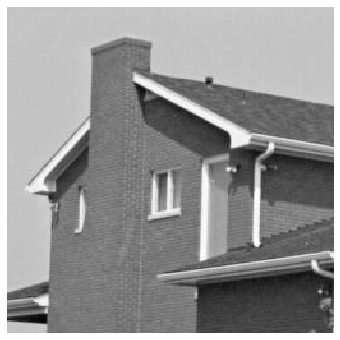

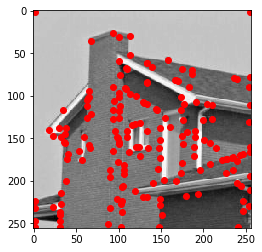

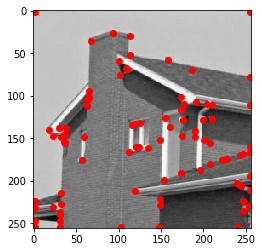

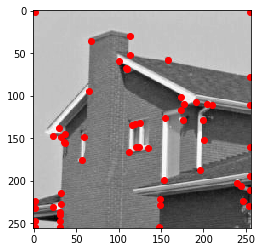

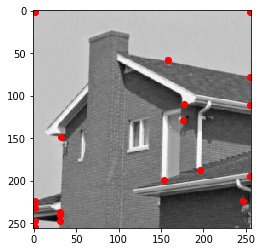

In [14]:
imshow(house2_png)

displayCorner(house2_png,2.1,0.04,10**9)
displayCorner(house2_png,2.1,0.04,10**10)
displayCorner(house2_png,2.1,0.04,10**11)
displayCorner(house2_png,2.1,0.04,10**12)

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

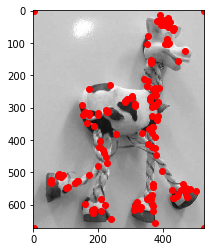

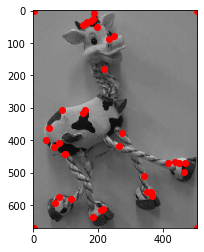

In [25]:
toyhorse1=np.array(Image.open('img/toyHorse1.png'))
toyhorse2=np.array(Image.open('img/toyHorse2.png'))
displayCorner(toyhorse1,2.1,0.04,10**11)
displayCorner(toyhorse2,2.1,0.04,10**11)

2) What are the dynamic ranges of these two images ?

In [16]:
print(np.amax(toyhorse1)-np.amin(toyhorse1))
print(np.amax(toyhorse2)-np.amin(toyhorse2))

254
253


La première image a une dynamique de 254.
La deuxième image a une dynamique de 253.

3) What are the transformations beetween the two images ?

Il y a eu une rotation entre la première et la deuxième image. De plus l'angle de vue est légérement différent (on voit mieux le museau sur la deuxième image que sur la première). Enfin, bien que ces 2 images aient une dynamique similaire, la deuxième est beaucoup plus sombre.

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

En changeant la rotation et en changeant la luminosité, on remarque que certains points restent les mêmes sur les 2 images (en particulier les taches sur le ventre de la girafe). Toutefois, la détection n'est pas invariante car beaucoup plus de points sont présents sur la première image. Cela est probablement dû au fait que cette image est plus lumineuse, on pourrait remédier à cela en adaptant la valeur de seuil en fonction de la luminosité de l'image.

Tests supplémentaires :


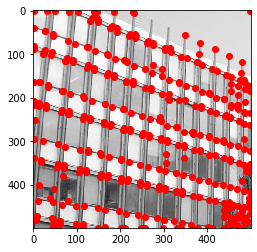

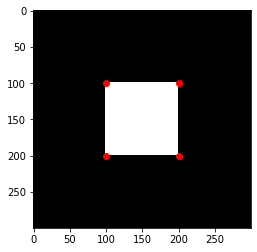

In [26]:
print("Tests supplémentaires :")
rectangle=np.array(Image.open('img/rectangle.png'))
jussieu=np.array(Image.open('img/Jussieu_wikipedia.jpg'))

displayCorner(jussieu,2.1,0.04,10**11)
displayCorner(rectangle,1.0,0.04,10**11)